# Score Predictions

Evaluate the different model predictions with the actual outcomes of fixtures using Ranked Probability Score.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

from ranked_probability_score import ranked_probability_score, match_outcome

In [3]:
# Get fixture outcomes
outcomes = pd.read_csv("../../data/fivethirtyeight/spi_matches.csv")
outcomes = (
    outcomes
    .loc[(outcomes['league_id'] == 2411) | (outcomes['league_id'] == 2412)]
    .dropna()
    )

## Baselines

In [4]:
from baselines import Baselines

# Get GW dates
fixtures = (
    pd.read_csv("../../data/fpl_official/vaastav/data/2021-22/fixtures.csv")
    .loc[:, ['event', 'kickoff_time']])
fixtures["kickoff_time"] = pd.to_datetime(fixtures["kickoff_time"]).dt.date

# Get only EPL games from the current season
season_games = (
    outcomes
    .loc[outcomes['league_id'] == 2411]
    .loc[outcomes['season'] == 2021]
    )
season_games["kickoff_time"] = pd.to_datetime(season_games["date"]).dt.date

# Merge outcomes with GW dates
season_games = (
    pd.merge(
        season_games,
        fixtures,
        left_on='kickoff_time',
        right_on='kickoff_time')
    .drop_duplicates()
    )

baselines = Baselines(season_games)

# Add the home team and away team index for running inference
idx = (
    pd.DataFrame()
    .assign(team=baselines.teams)
    .assign(team_index=np.arange(baselines.league_size)))

season_games = (
    pd.merge(season_games, idx, left_on="team1", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .drop_duplicates()
    .merge(idx, left_on="team2", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    .sort_values("date")
)

### Uniform Odds

In [5]:
predictions_uniform = baselines.evaluate(season_games, 'uniform')
f"{(np.mean(predictions_uniform.rps)*100):.2f}"

'23.92'

### Home bias

In [6]:
predictions_home = baselines.evaluate(season_games, 'home')
f"{(np.mean(predictions_home.rps)*100):.2f}"

'45.53'

### Draw bias

In [7]:
predictions_draw = baselines.evaluate(season_games, 'draw')
f"{(np.mean(predictions_draw.rps)*100):.2f}"

'38.42'

### Away bias

In [8]:
predictions_away = baselines.evaluate(season_games, 'away')
f"{(np.mean(predictions_away.rps)*100):.2f}"

'54.47'

### Random odds

In [9]:
predictions_random = baselines.evaluate(season_games, 'random')
f"{(np.mean(predictions_random.rps)*100):.2f}"

'27.51'

### Bookies Odds

In [10]:
predictions_bookies = baselines.evaluate(season_games, 'bookies', '../../')
f"{(np.mean(predictions_bookies.rps)*100):.2f}"

'18.90'

### Bookies Favorite

In [11]:
predictions_favorite = baselines.evaluate(season_games, 'favorite', '../../')
f"{(np.mean(predictions_favorite.rps)*100):.2f}"

'61.32'

### SPI

In [12]:
from spi import SPI

spi = SPI(outcomes.loc[outcomes.season == 2021])

predictions_spi = spi.evaluate()
predictions_spi = (
    pd.merge(
        (
            pd.read_csv("../../data/predictions/fixtures/dixon_coles.csv")
            .loc[:, ['team1', 'team2', 'event']]),
        predictions_spi,
        how='left',
        left_on=['team1', 'team2'],
        right_on=['team1', 'team2']
    )
)
f"{(np.mean(predictions_spi.rps)*100):.2f}"

'19.20'

## Modeling Outcomes

### Thurstone Mosteller

In [13]:
predictions_tm = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_tm["winner"] = match_outcome(predictions_tm)
predictions_tm["rps"] = (
    predictions_tm.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_tm['rps'])*100):.2f}"

'20.94'

### Bradley Terry

In [14]:
predictions_bt = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/bradley_terry.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_bt["winner"] = match_outcome(predictions_bt)
predictions_bt["rps"] = (
    predictions_bt.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_bt['rps'])*100):.2f}"

'21.08'

### Elo Rating

In [15]:
predictions_elo = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/elo.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_elo["winner"] = match_outcome(predictions_elo)
predictions_elo["rps"] = (
    predictions_elo.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_elo['rps'])*100):.2f}"

'19.62'

## Modeling Goals Scored

### Independent Poisson

In [16]:
predictions_ip = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/independent_poisson.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_ip["winner"] = match_outcome(predictions_ip)
predictions_ip["rps"] = (
    predictions_ip.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_ip['rps'])*100):.2f}"

'19.30'

### Bivariate Poisson

In [17]:
predictions_bp = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/bivariate_poisson.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_bp["winner"] = match_outcome(predictions_bp)
predictions_bp["rps"] = (
    predictions_bp.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]], row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_bp['rps'])*100):.2f}"

'19.27'

### Dixon Coles

In [18]:
predictions_dc = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/dixon_coles.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_dc["winner"] = match_outcome(predictions_dc)
predictions_dc["rps"] = (
    predictions_dc.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]], row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_dc['rps'])*100):.2f}"

'19.27'

### Bayesian

In [19]:
predictions_bayesian = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/bayesian.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()

predictions_bayesian["winner"] = match_outcome(predictions_bayesian)
predictions_bayesian["rps"] = (
    predictions_bayesian.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]], row["winner"]
        ), axis=1)
    )

f"{(np.mean(predictions_bayesian['rps'])*100):.2f}"

'19.43'

# Comparison

In [20]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

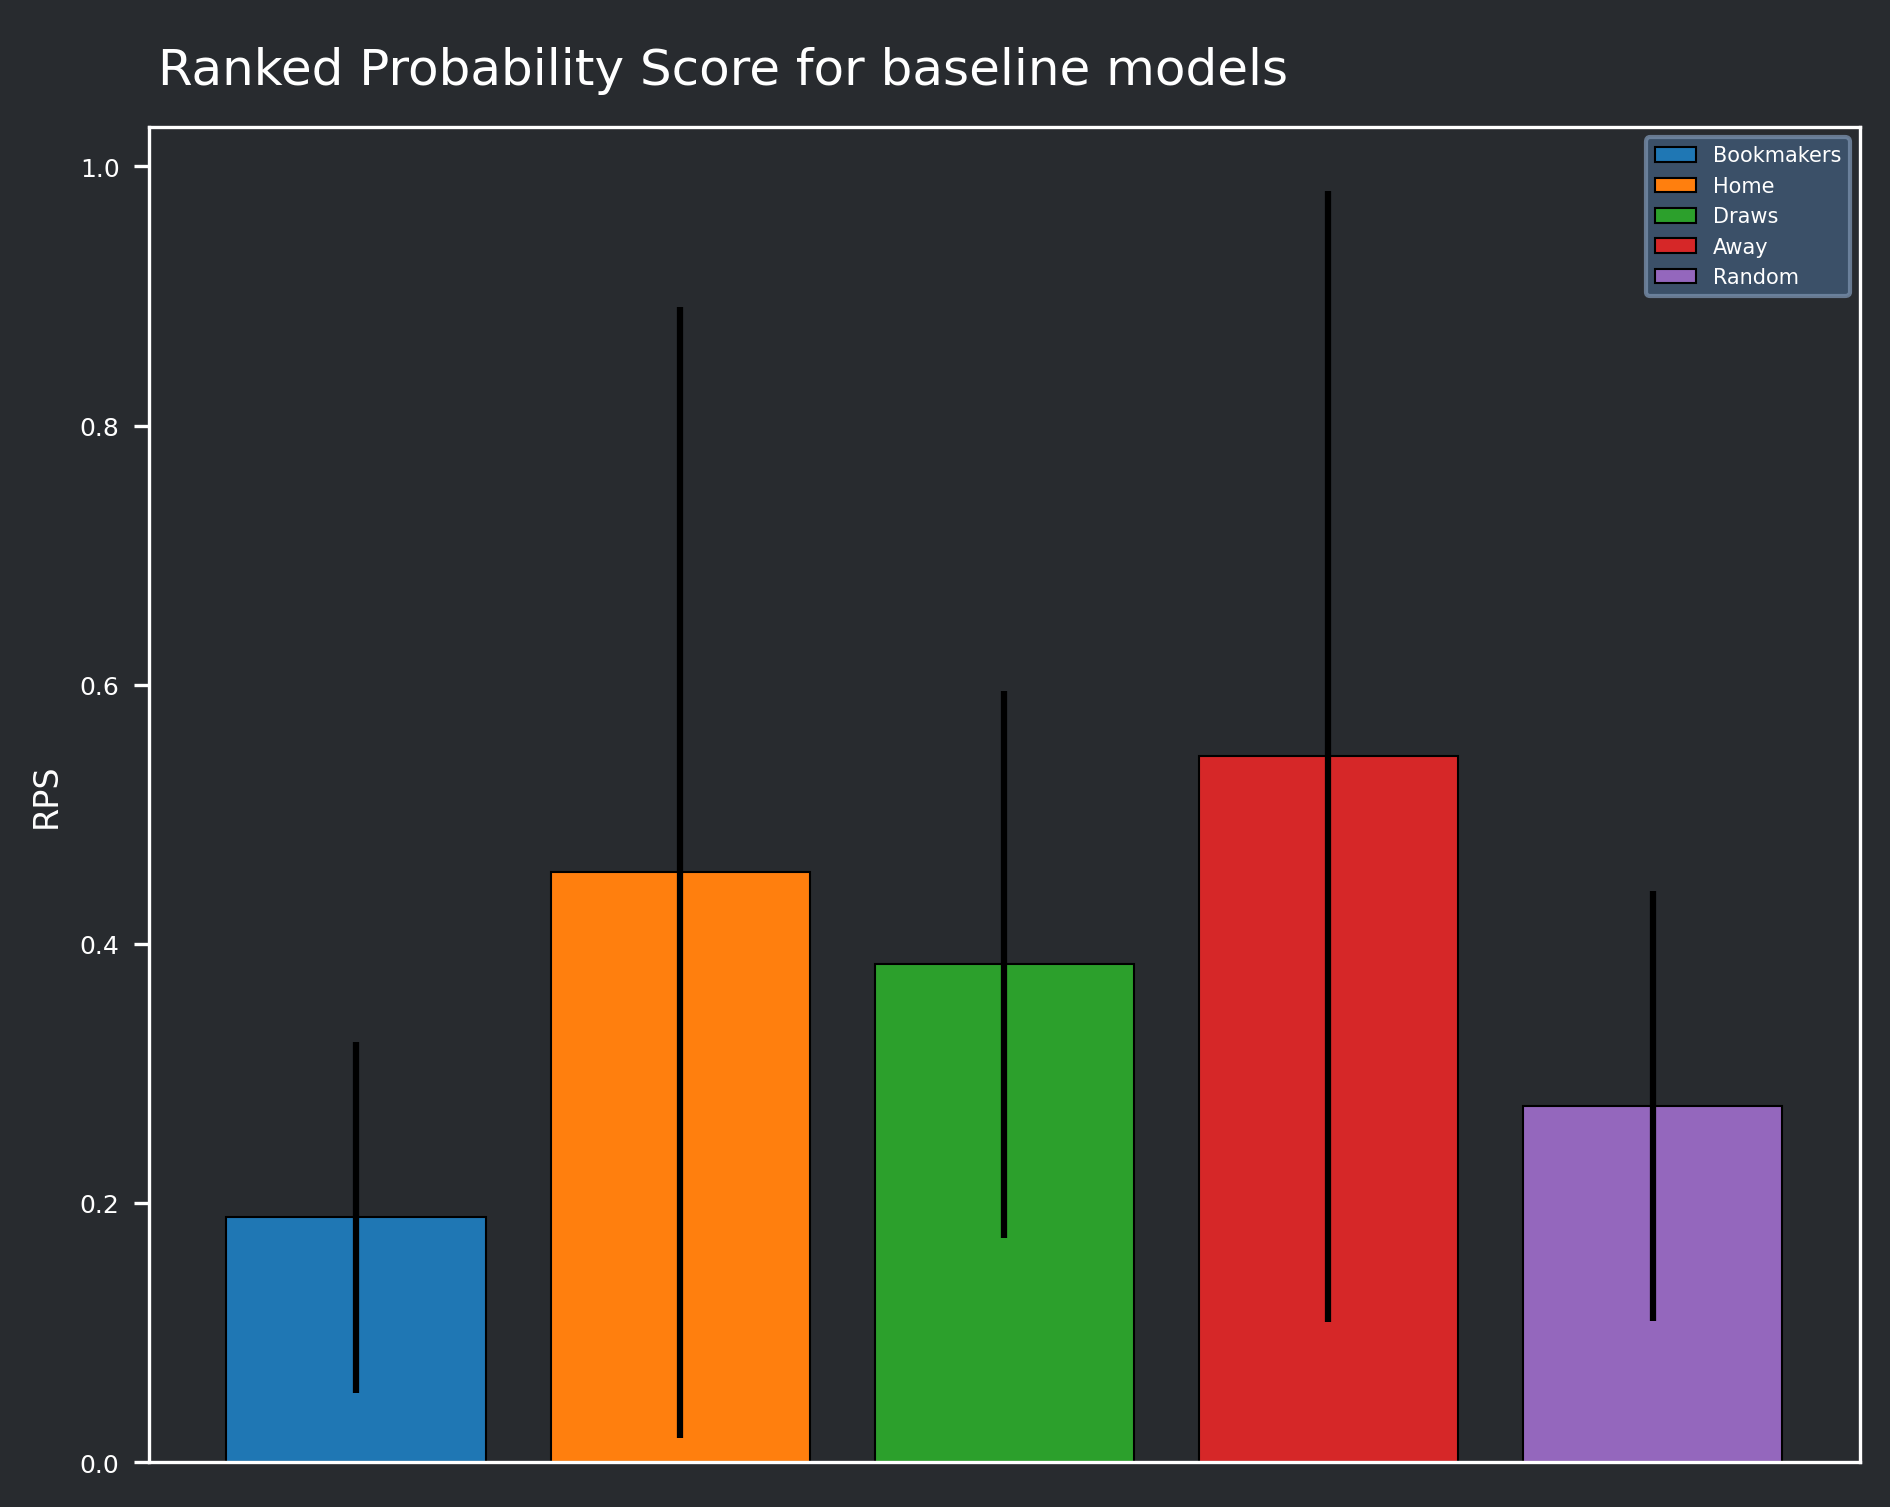

In [21]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.bar(
    [0], predictions_bookies['rps'].mean(),
    yerr = predictions_bookies['rps'].std(),
    label='Bookmakers',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [1], predictions_home['rps'].mean(),
    yerr = predictions_home['rps'].std(),
    label='Home',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [2], predictions_draw['rps'].mean(),
    yerr = predictions_draw['rps'].std(),
    label='Draws',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [3], predictions_away['rps'].mean(),
    yerr = predictions_away['rps'].std(),
    label='Away',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [4], predictions_random['rps'].mean(),
    yerr = predictions_random['rps'].std(),
    label='Random',
    edgecolor='black', linewidth=0.5)

ax.set_ylabel('RPS' , fontsize=8, color=text_color)

legend = ax.legend(prop={'size': 5}, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')

ax.set_xticks([], minor=False)

fig_text(
    x=0.09, y=1.025,
    s="Ranked Probability Score for baseline models",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

# fig_text(
#     x=0.8, y=0.01,
#     s="Created by <Paul Fournier>",
#     highlight_textprops=[{"fontstyle": "italic"}],
#     fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

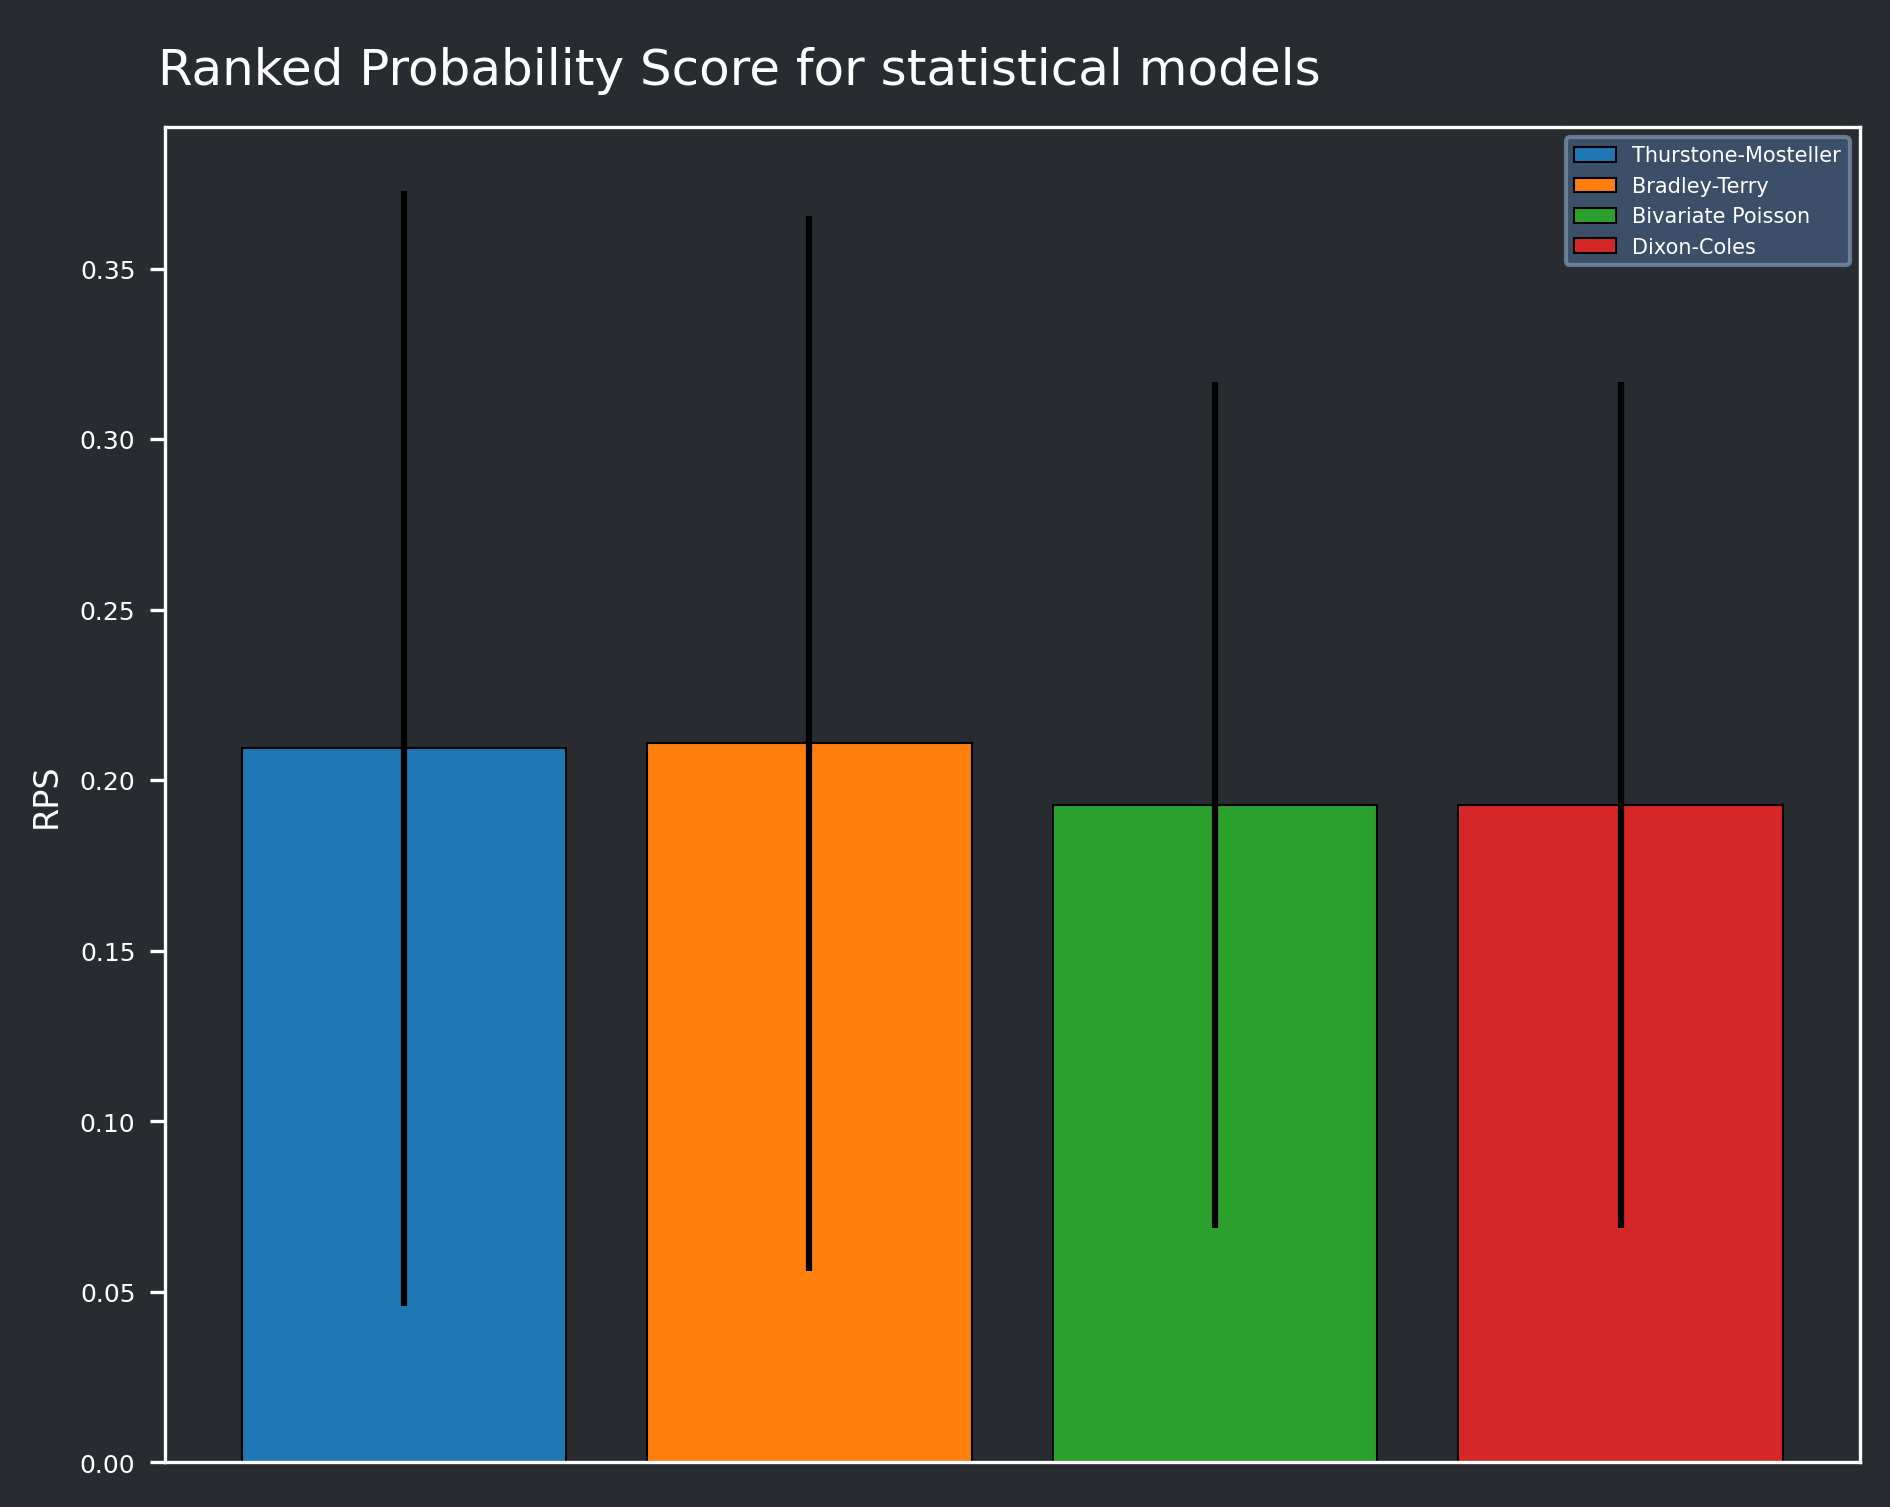

In [22]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.bar(
    [0], predictions_tm['rps'].mean(),
    yerr = predictions_tm['rps'].std(),
    label='Thurstone-Mosteller',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [1], predictions_bt['rps'].mean(),
    yerr = predictions_bt['rps'].std(),
    label='Bradley-Terry',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [2], predictions_bp['rps'].mean(),
    yerr = predictions_bp['rps'].std(),
    label='Bivariate Poisson',
    edgecolor='black', linewidth=0.5)
ax.bar(
    [3], predictions_dc['rps'].mean(),
    yerr = predictions_dc['rps'].std(),
    label='Dixon-Coles',
    edgecolor='black', linewidth=0.5)

ax.set_ylabel('RPS' , fontsize=8, color=text_color)

legend = ax.legend(prop={'size': 5}, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')

ax.set_xticks([], minor=False)

fig_text(
    x=0.09, y=1.025,
    s="Ranked Probability Score for statistical models",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

# fig_text(
#     x=0.8, y=0.01,
#     s="Created by <Paul Fournier>",
#     highlight_textprops=[{"fontstyle": "italic"}],
#     fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

In [23]:
predictions_tm_0 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_no_decay.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_0["winner"] = match_outcome(predictions_tm_0)
predictions_tm_0["rps"] = (
    predictions_tm_0.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_00005 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_00005.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_00005["winner"] = match_outcome(predictions_tm_00005)
predictions_tm_00005["rps"] = (
    predictions_tm_00005.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_0001 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_0001.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_0001["winner"] = match_outcome(predictions_tm_0001)
predictions_tm_0001["rps"] = (
    predictions_tm_0001.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_001 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_001.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_001["winner"] = match_outcome(predictions_tm_001)
predictions_tm_001["rps"] = (
    predictions_tm_001.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_0025 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_0025.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_0025["winner"] = match_outcome(predictions_tm_0025)
predictions_tm_0025["rps"] = (
    predictions_tm_0025.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

predictions_tm_005 = (
    pd.merge(
        pd.read_csv("../../data/predictions/fixtures/thurstone_mosteller_005.csv"),
        outcomes.loc[:, ['team1', 'team2', 'date', 'score1', 'score2']],
        how='left',
        left_on=['team1', 'team2', 'date'],
        right_on=['team1', 'team2', 'date'])
    ).dropna()
predictions_tm_005["winner"] = match_outcome(predictions_tm_005)
predictions_tm_005["rps"] = (
    predictions_tm_005.apply(
        lambda row: ranked_probability_score(
            [row["home_win_p"], row["draw_p"], row["away_win_p"]],
            row["winner"]
        ), axis=1)
    )

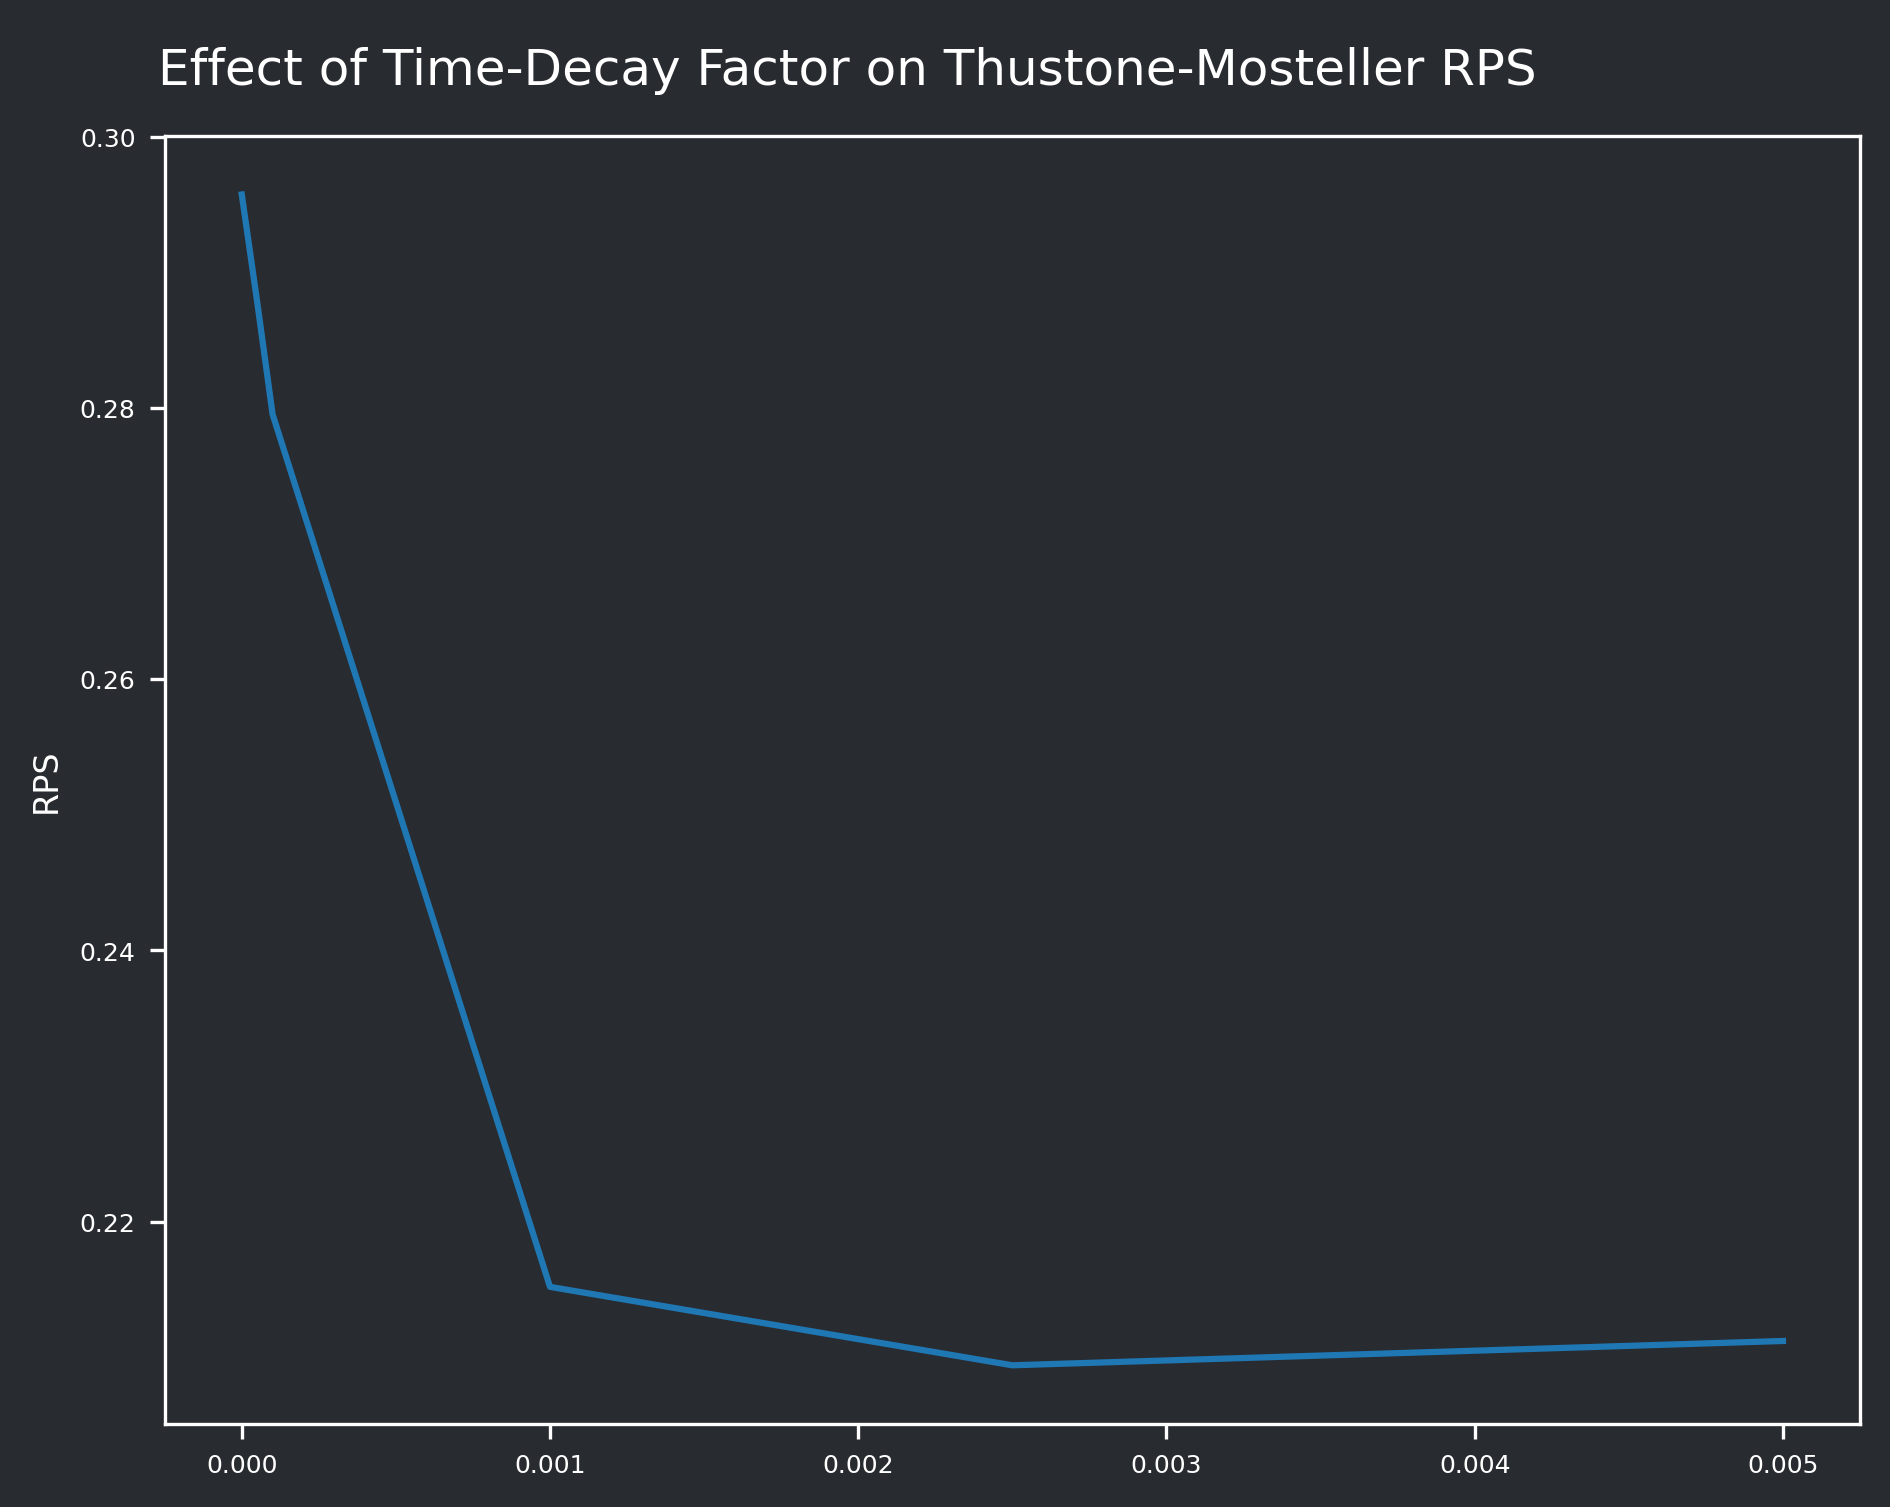

In [24]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(
    np.array([0, 0.00005, 0.0001, 0.001, 0.0025, 0.005]), 
    np.array([
        predictions_tm_0['rps'].mean(),
        predictions_tm_00005['rps'].mean(),
        predictions_tm_0001['rps'].mean(),
        predictions_tm_001['rps'].mean(),
        predictions_tm_0025['rps'].mean(),
        predictions_tm_005['rps'].mean()]))

ax.set_ylabel('RPS' , fontsize=8, color=text_color)

fig_text(
    x=0.09, y=1.025,
    s="Effect of Time-Decay Factor on Thustone-Mosteller RPS",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

# fig_text(
#     x=0.8, y=0.01,
#     s="Created by <Paul Fournier>",
#     highlight_textprops=[{"fontstyle": "italic"}],
#     fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()

### EDA

[[119   0  44]
 [ 55   0  33]
 [ 41   0  88]]


/tmp/ipykernel_10192/522034620.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['Home', 'Draw', 'Away'])
/tmp/ipykernel_10192/522034620.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['Home', 'Draw', 'Away'])


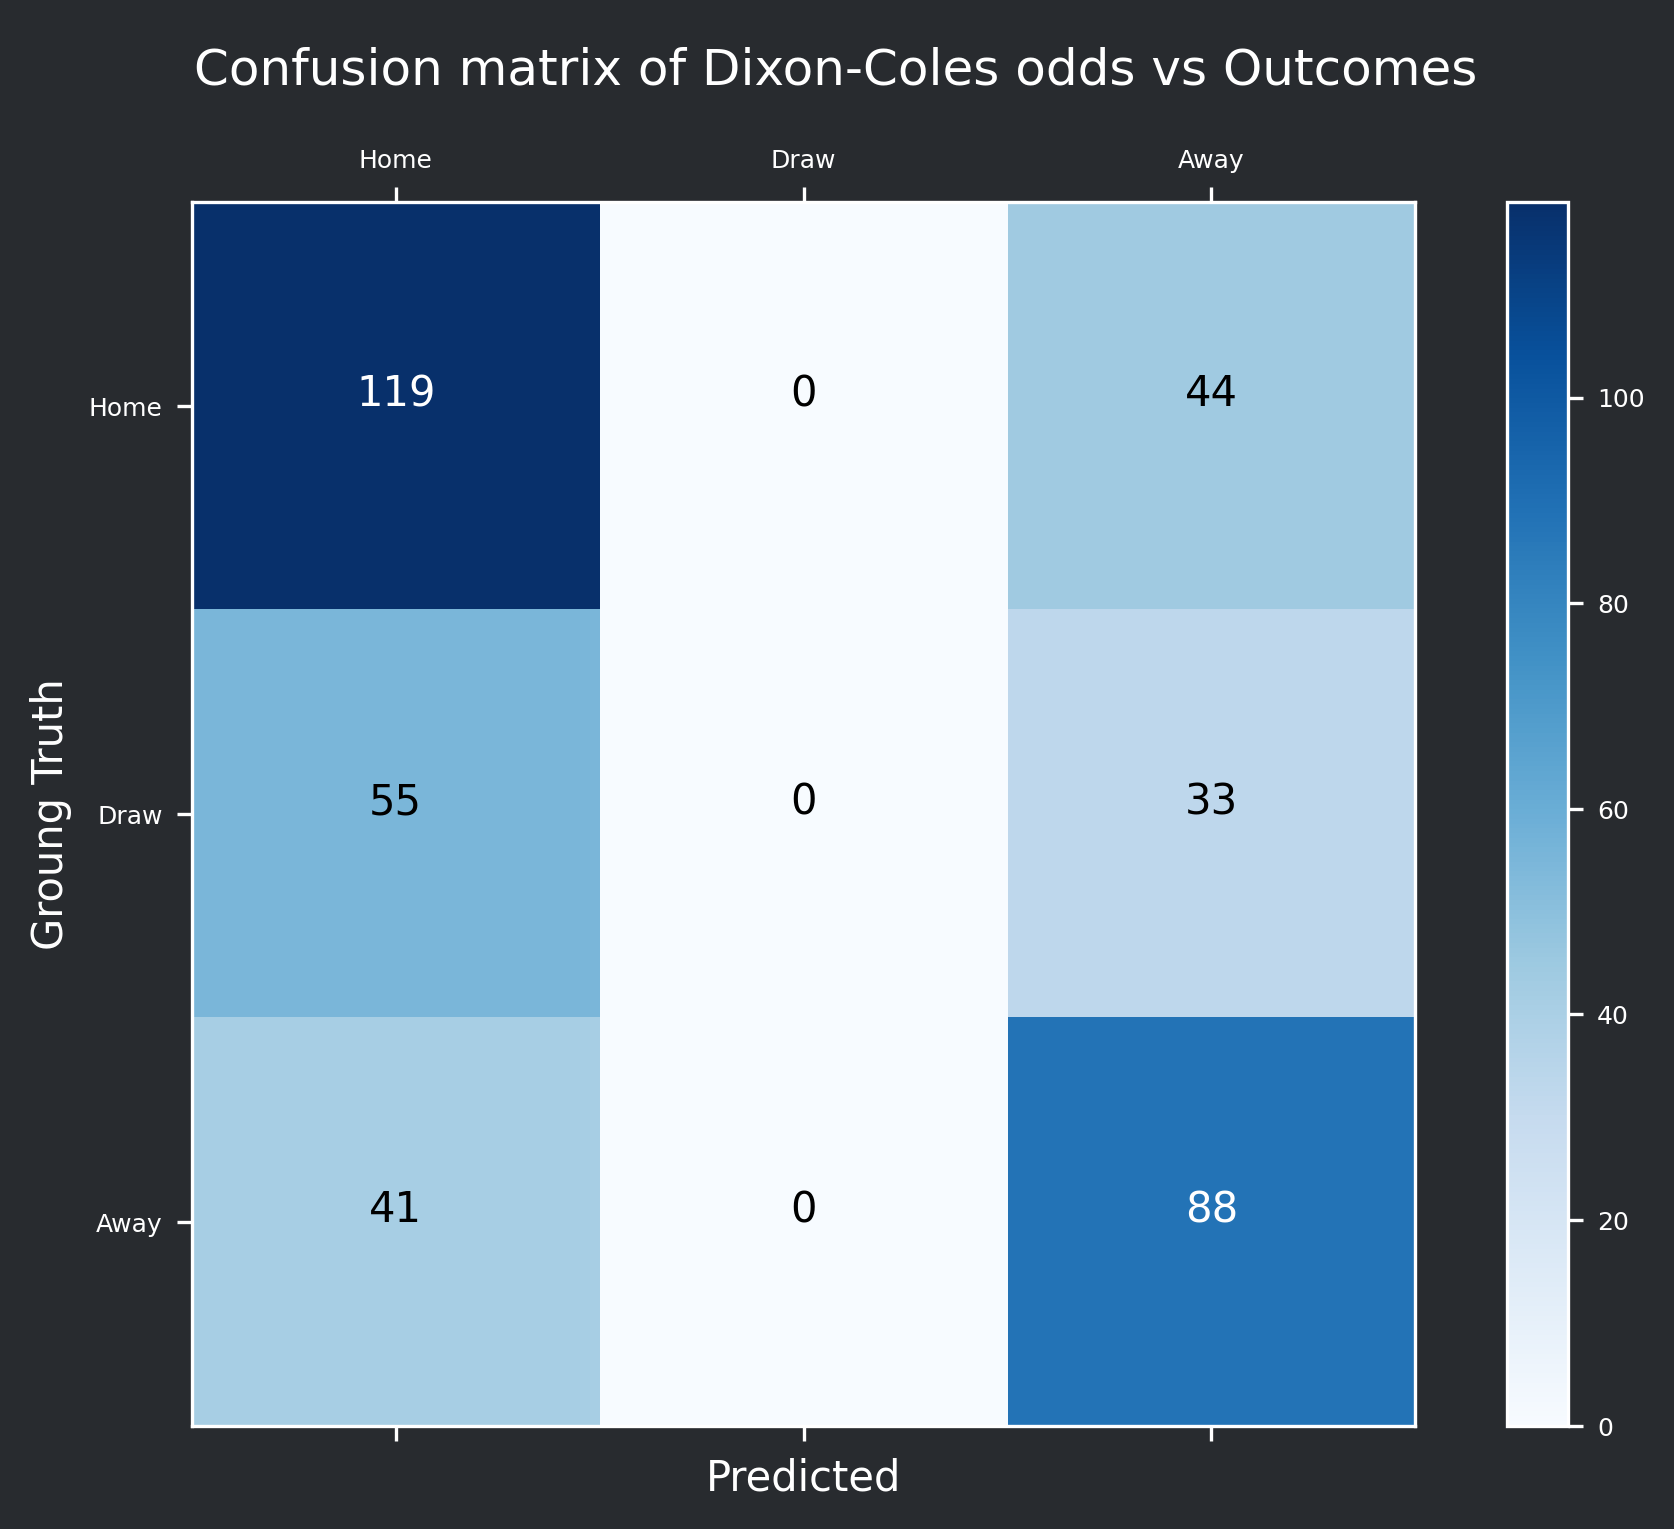

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(
    predictions_dc['winner'],
    np.argmax(
        predictions_dc[['home_win_p', 'draw_p', 'away_win_p']].values,
        axis=1
    ))

normalize = False
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

cax = ax.matshow(cm, cmap=plt.get_cmap('Blues'))
fig.colorbar(cax)

thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(
            j, i, "{:0.4f}".format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(
            j, i, "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

ax.set_xticklabels([''] + ['Home', 'Draw', 'Away'])
ax.set_yticklabels([''] + ['Home', 'Draw', 'Away'])

ax.set_xlabel('Predicted')
ax.xaxis.label.set_color('w')
ax.set_ylabel('Groung Truth')
ax.yaxis.label.set_color('w')

fig_text(
    x=0.15, y=1.04,
    s="Confusion matrix of Dixon-Coles odds vs Outcomes",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

plt.show()

[[136   0  27]
 [ 57   0  31]
 [ 44   0  85]]


/tmp/ipykernel_10192/928524455.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['Home', 'Draw', 'Away'])
/tmp/ipykernel_10192/928524455.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['Home', 'Draw', 'Away'])


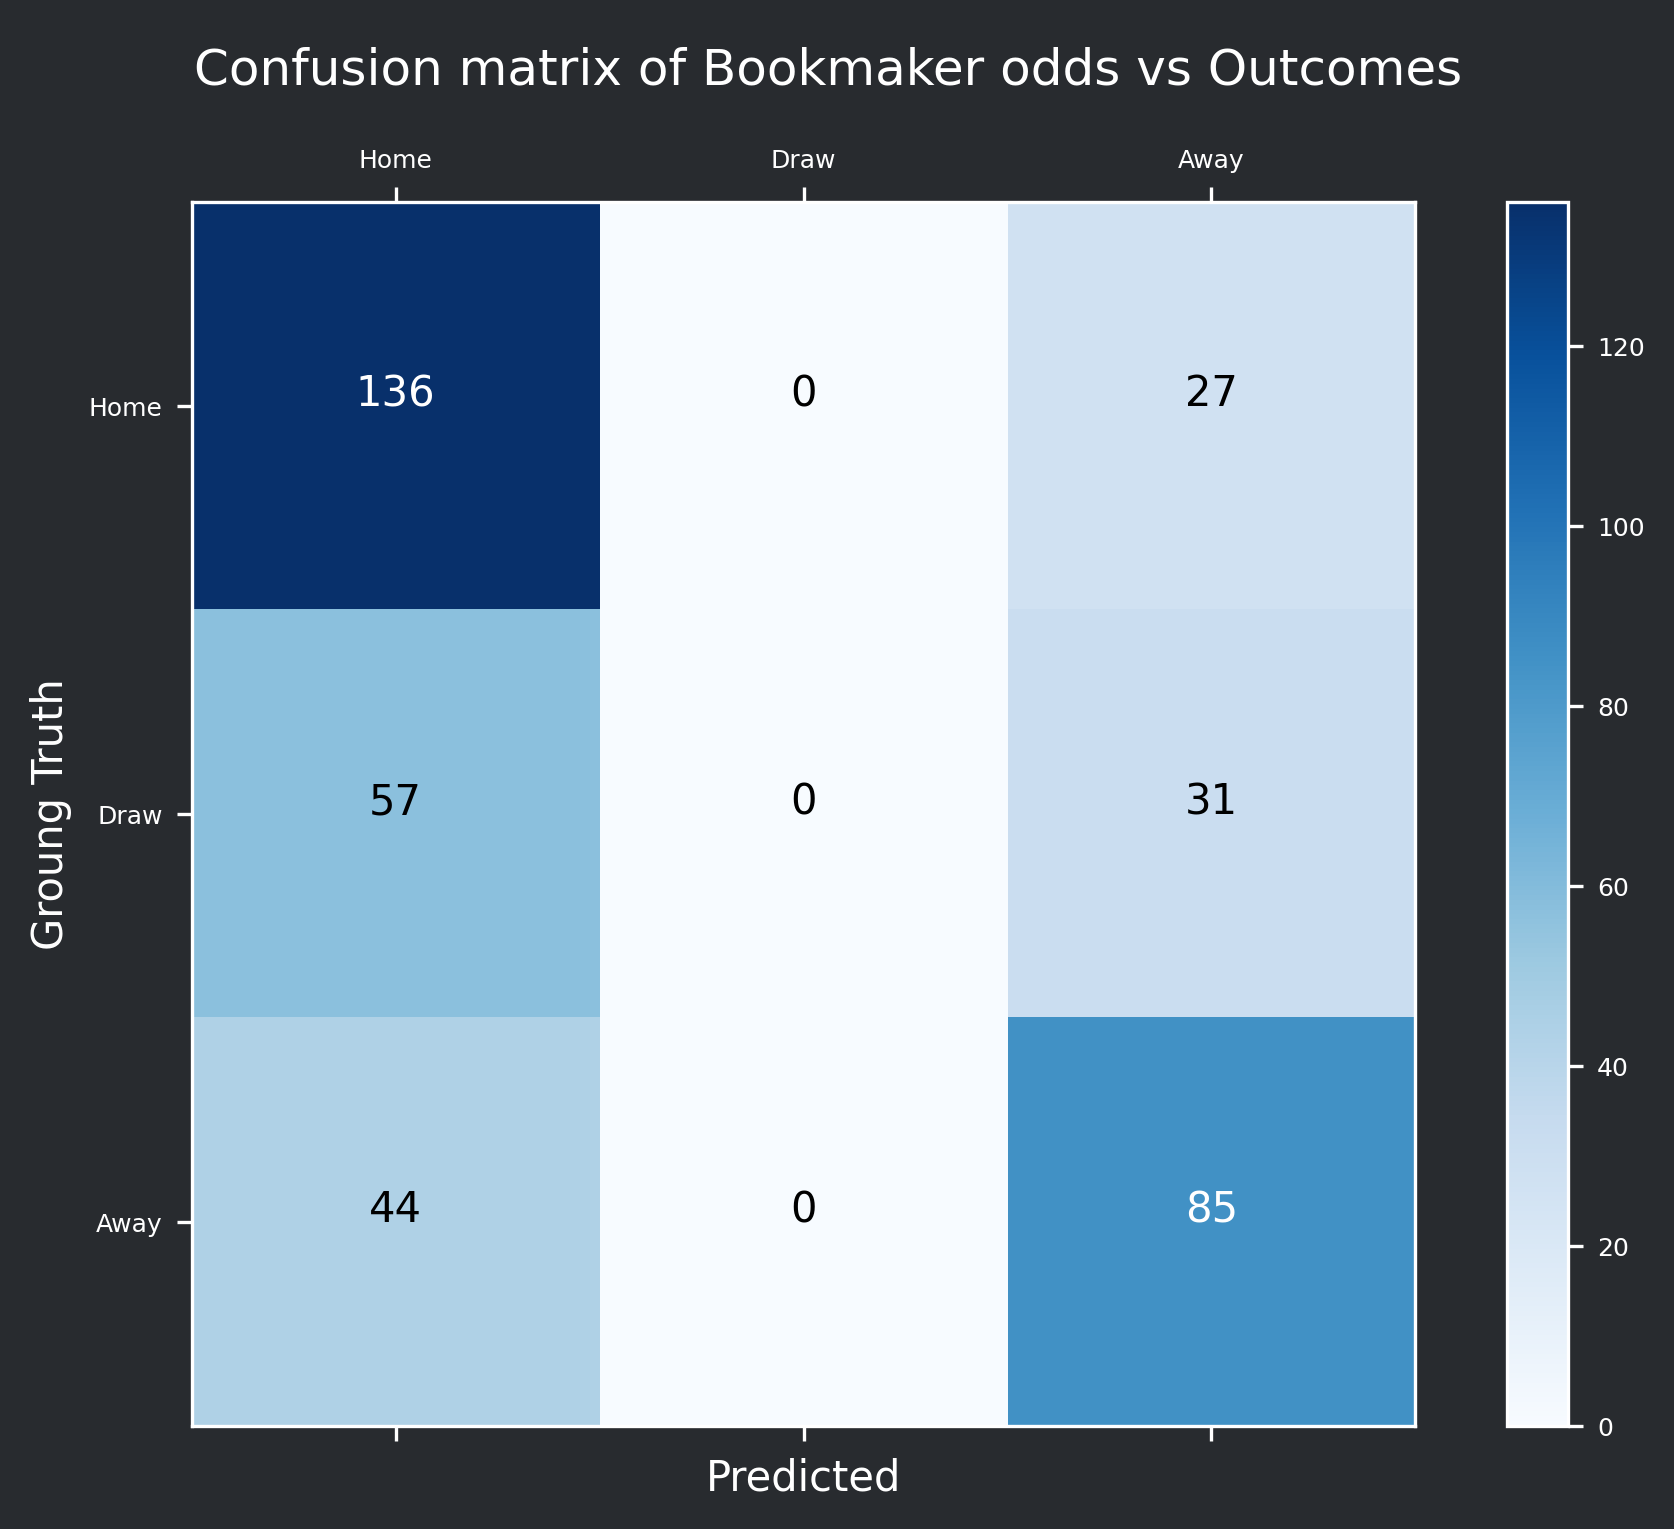

In [28]:
cm = confusion_matrix(
    match_outcome(predictions_bookies),
    np.argmax(
        predictions_bookies[['home_win_p', 'draw_p', 'away_win_p']].values,
        axis=1
    ))

normalize = False
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

fig, ax = plt.subplots(tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

cax = ax.matshow(cm, cmap=plt.get_cmap('Blues'))
fig.colorbar(cax)

thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(
            j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(
            j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

ax.set_xticklabels([''] + ['Home', 'Draw', 'Away'])
ax.set_yticklabels([''] + ['Home', 'Draw', 'Away'])

ax.set_xlabel('Predicted')
ax.xaxis.label.set_color('w')
ax.set_ylabel('Groung Truth')
ax.yaxis.label.set_color('w')

fig_text(
    x=0.15, y=1.04,
    s="Confusion matrix of Bookmaker odds vs Outcomes",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

plt.show()